In [1]:
from sim_tools import *
from classy import Class
import MAS_library as MASL
import Pk_library as PKL

In [2]:
#
# Matter power spectrum for ICs in Mpc/h units
#
Om=0.3
Ob=0.05
ns=0.965
s8=0.8
h=0.7
cls = Class()
cls.set({'output':'mPk', 'Omega_cdm':Om - Ob, 'Omega_b':Ob, 'h':h, 'n_s':ns, 'sigma8':s8, 'P_k_max_h/Mpc':1.e2, 'z_pk':0})
cls.compute()
#
kk = np.logspace(-5, 2, 1024)
pp = np.array([cls.pk(tk * cls.h(), 0.) * cls.h() ** 3 for tk in kk])
tt = np.sqrt(pp / pp[0] * (kk[0] / kk) ** ns)
np.savetxt('../test_potential/input_transfer_function_z0.00e+00.txt', np.array([kk, tt]).T, fmt = '%.8e %.8e')

In [4]:
def getB1(P1, P2, P3) :
    return (P1 * P2 + P2 * P3 + P3 * P1)

def getB2(P1, P2, P3) :
    return (P1 * P2 * P3) ** (2./3.)

def getB3(P1, P2, P3) :
    B = np.zeros(P3.size)
    Ps = [P1, P2, P3]
    for i, P in enumerate(Ps) :
        B += P * Ps[(i + 1) % 3] ** (1./3.) * Ps[(i + 2) % 3] ** (2. / 3.)
        B += P * Ps[(i + 2) % 3] ** (1./3.) * Ps[(i + 1) % 3] ** (2. / 3.)
    return B

def getBLC(Pks, fNL = 1.) :
    return 2. * fNL * getB1(Pks[0], Pks[1], Pks[2:])

def getBEQ(Pks, fNL = 1.) :
    B1 = getB1(Pks[0], Pks[1], Pks[2:])
    B2 = getB2(Pks[0], Pks[1], Pks[2:])
    B3 = getB3(Pks[0], Pks[1], Pks[2:])
    return 6. * fNL * (-B1 - 2. * B2 + B3)

def getBOR(Pks, fNL = 1.) :
    B1 = getB1(Pks[0], Pks[1], Pks[2:])
    B2 = getB2(Pks[0], Pks[1], Pks[2:])
    B3 = getB3(Pks[0], Pks[1], Pks[2:])
    return 6. * fNL * (-3. * B1 - 8. * B2 + 3. * B3)

def getQLC(Pks, fNL = 1.) :
    B1 = getB1(Pks[0], Pks[1], Pks[2:])
    return getBLC(Pks, fNL) / B1

def getQEQ(Pks, fNL = 1.) :
    B1 = getB1(Pks[0], Pks[1], Pks[2:])
    return  getBEQ(Pks, fNL) / B1

def getQOR(Pks, fNL = 1.) :
    B1 = getB1(Pks[0], Pks[1], Pks[2:])
    return  getBOR(Pks, fNL) / B1

def getQspecFromPk(mode, k1, k2, thetas, fNL = 1.) :
    PP = interp1d(kk, pp, kind = 3)
    p1 = k1 ** (ns - 4)
    p2 = k2 ** (ns - 4)
    k3s = np.sqrt((k1 * np.sin(thetas))**2 + (k1 * np.cos(thetas) + k2)**2)
    p3s = k3s ** (ns - 4)
    if mode == 'LC' :
        return getQLC(np.array([p1, p2] + list(p3s)), fNL)
    elif mode == 'EQ' :
        return getQEQ(np.array([p1, p2] + list(p3s)), fNL)
    elif mode == 'OR' :
        return getQOR(np.array([p1, p2] + list(p3s)), fNL)
    else :
        raise ValueError  

def singleBispec(fn, theta, k1, k2, nthread = 28, BoxSize = 1.e3, ngrid = 128) :
    potential = np.array(np.reshape(load_file(fn, 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)
    return PKL.Bk(potential, BoxSize, k1, k2, theta, 'None', threads = nthread)

def pairedBispec(fn0, dn1, theta, k1, k2, nthread = 28, BoxSize = 1.e3, ngrid = 128) :
    potential = 0.5 * np.array(np.reshape(load_file(fn0, 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)
    potential += 0.5 * np.array(np.reshape(load_file(fn1, 1, np.float64), (ngrid, ngrid, ngrid)), dtype = np.float32)
    return PKL.Bk(potential, BoxSize, k1, k2, theta, 'None', threads = nthread)

In [25]:
theta = np.linspace(0., np.pi, 16)
k1 = 2.e-1
k2 = 3.e-1
nthread = 28

Bs, dQs = {}, {}
for mode in ['G', 'LC', 'EQ', 'OR'] :
    Bs[mode] = []
    if mode != 'G' :
        dQs[mode] = []
for i in range(10) :
    for flip in [0,1] :
        fn = '../test_potential/Meshes/G/potential_G_%d_%d.dat' % (i, flip)
        Bs['G'].append(singleBispec(fn, theta, k1, k2, nthread, 1.e3, 256))
        for mode in ['LC', 'EQ', 'OR'] :
            fn = '../test_potential/Meshes/%s/potential_%s_%d_%d.dat' % (mode, mode, i, flip)
            Bs[mode].append(singleBispec(fn, theta, k1, k2, nthread, 1.e3, 256))
            dQs[mode].append(Bs[mode][-1].Q - Bs['G'][-1].Q)


Computing bispectrum of the field...
Time to compute bispectrum = 4.69

Computing bispectrum of the field...
Time to compute bispectrum = 4.68

Computing bispectrum of the field...
Time to compute bispectrum = 4.73

Computing bispectrum of the field...
Time to compute bispectrum = 4.76

Computing bispectrum of the field...
Time to compute bispectrum = 4.65

Computing bispectrum of the field...
Time to compute bispectrum = 4.68

Computing bispectrum of the field...
Time to compute bispectrum = 4.64

Computing bispectrum of the field...
Time to compute bispectrum = 4.70

Computing bispectrum of the field...
Time to compute bispectrum = 4.65

Computing bispectrum of the field...
Time to compute bispectrum = 4.69

Computing bispectrum of the field...
Time to compute bispectrum = 4.68

Computing bispectrum of the field...
Time to compute bispectrum = 4.66

Computing bispectrum of the field...
Time to compute bispectrum = 4.66

Computing bispectrum of the field...
Time to compute bispectrum

In [63]:
mdQs, edQs = {}, {}
for mode in ['LC', 'EQ', 'OR'] :
    mdQs[mode], edQs[mode] = bootstrap(dQs[mode], 10000)

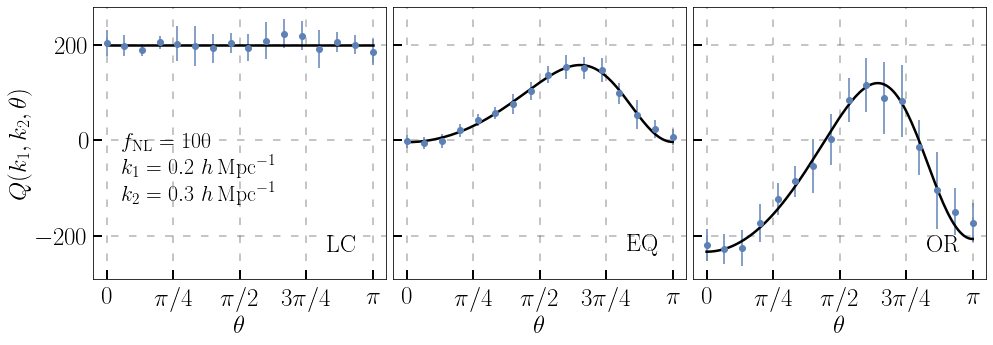

In [64]:
with userc() :
    fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharey = True)
    plt.subplots_adjust(wspace = 0.025)
    for i, mode in enumerate(['LC', 'EQ', 'OR']) :
        ax = axs[i]
        ax.errorbar(theta, mdQs[mode], edQs[mode], ls = 'none', marker = 'o');
        tth = np.linspace(0., np.pi, 128)
        ax.plot(tth, getQspecFromPk(mode, k1, k2, tth, 100.), lw = 2.5, color = 'black');
        ax.text(0.8, 0.1, '$\mathrm{' + mode + '}$', fontsize = 24, transform = ax.transAxes);
        if mode == 'LC' :
            text = '$f_{\mathrm{NL}} = 100$\n'
            text += '$k_1 = 0.2\ h\,\mathrm{Mpc}^{-1}$\n'
            text += '$k_2 = 0.3\ h\,\mathrm{Mpc}^{-1}$\n'
            ax.text(0.1, 0.2, text, fontsize = 22, transform = ax.transAxes);
        ax.grid(dashes = (5, 7), color = 'black')
        ax.set_xlabel(r'$\theta$');
        ax.set_xticks(np.arange(0, np.pi + 0.01, np.pi/4))
        labels = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
        ax.set_xticklabels(labels)
    axs[0].set_ylabel(r'$Q(k_1, k_2, \theta)$');
    plt.savefig('Q_shape_test_minus_G.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight');

In [65]:
mQs, eQs = {}, {}
for mode in ['LC', 'EQ', 'OR'] :
    mQs[mode], eQs[mode] = bootstrap([0.5 * (Bs[mode][2 * i].Q + Bs[mode][2 * i + 1].Q) for i in range(int(len(Bs[mode])/2))], 10000)

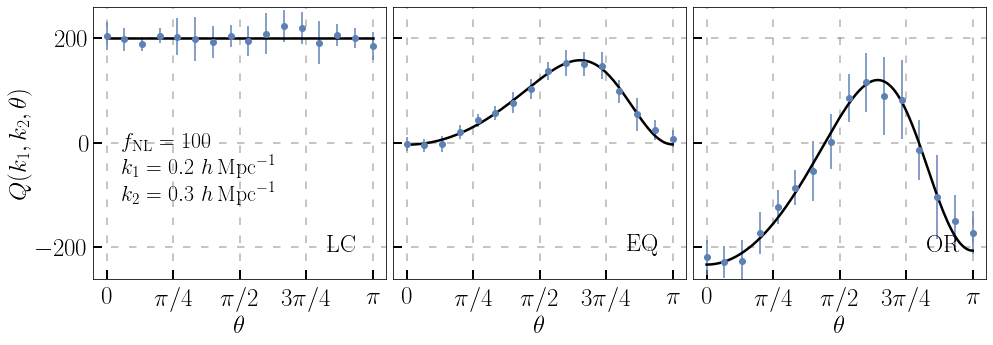

In [66]:
with userc() :
    fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharey = True)
    plt.subplots_adjust(wspace = 0.025)
    for i, mode in enumerate(['LC', 'EQ', 'OR']) :
        ax = axs[i]
        ax.errorbar(theta, mQs[mode], eQs[mode], ls = 'none', marker = 'o');
        tth = np.linspace(0., np.pi, 128)
        ax.plot(tth, getQspecFromPk(mode, k1, k2, tth, 100.), lw = 2.5, color = 'black');
        ax.text(0.8, 0.1, '$\mathrm{' + mode + '}$', fontsize = 24, transform = ax.transAxes);
        if mode == 'LC' :
            text = '$f_{\mathrm{NL}} = 100$\n'
            text += '$k_1 = 0.2\ h\,\mathrm{Mpc}^{-1}$\n'
            text += '$k_2 = 0.3\ h\,\mathrm{Mpc}^{-1}$\n'
            ax.text(0.1, 0.2, text, fontsize = 22, transform = ax.transAxes);
        ax.grid(dashes = (5, 7), color = 'black')
        ax.set_xlabel(r'$\theta$');
        ax.set_xticks(np.arange(0, np.pi + 0.01, np.pi/4))
        labels = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
        ax.set_xticklabels(labels)
    axs[0].set_ylabel(r'$Q(k_1, k_2, \theta)$');
    axs[0].set_ylim(-260., 260.);
    plt.savefig('Q_shape_test_paired.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight');

In [68]:
mQs, eQs = {}, {}
for mode in ['LC', 'EQ', 'OR'] :
    mQs[mode], eQs[mode] = bootstrap([tB.Q for tB in Bs[mode]], 10000)

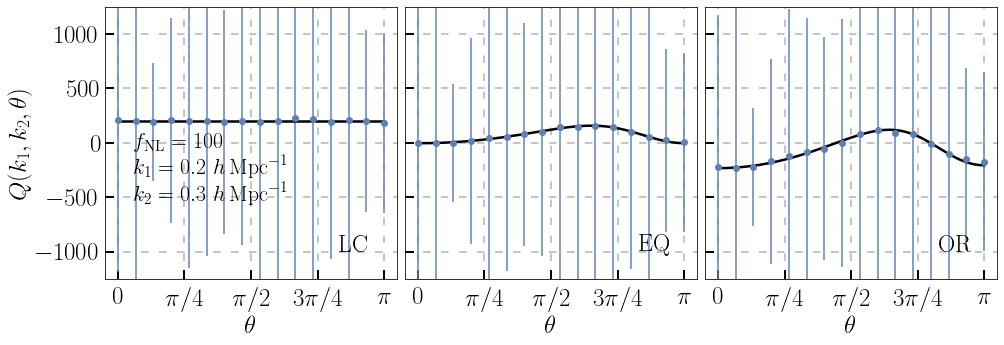

In [69]:
with userc() :
    fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharey = True)
    plt.subplots_adjust(wspace = 0.025)
    for i, mode in enumerate(['LC', 'EQ', 'OR']) :
        ax = axs[i]
        ax.errorbar(theta, mQs[mode], eQs[mode], ls = 'none', marker = 'o');
        tth = np.linspace(0., np.pi, 128)
        ax.plot(tth, getQspecFromPk(mode, k1, k2, tth, 100.), lw = 2.5, color = 'black');
        ax.text(0.8, 0.1, '$\mathrm{' + mode + '}$', fontsize = 24, transform = ax.transAxes);
        if mode == 'LC' :
            text = '$f_{\mathrm{NL}} = 100$\n'
            text += '$k_1 = 0.2\ h\,\mathrm{Mpc}^{-1}$\n'
            text += '$k_2 = 0.3\ h\,\mathrm{Mpc}^{-1}$\n'
            ax.text(0.1, 0.2, text, fontsize = 22, transform = ax.transAxes);
        ax.grid(dashes = (5, 7), color = 'black')
        ax.set_xlabel(r'$\theta$');
        ax.set_xticks(np.arange(0, np.pi + 0.01, np.pi/4))
        labels = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
        ax.set_xticklabels(labels)
    axs[0].set_ylabel(r'$Q(k_1, k_2, \theta)$');
    axs[0].set_ylim(-1250., 1250.);
    plt.savefig('Q_shape_not_paired.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight');